In [1]:
# load data
import deeplake
import numpy as np 
import tensorflow.keras as KERAS 
import tensorflow as tf
from src import *
import os
import matplotlib.pyplot as plt 

c:\Users\Lee\anaconda3\envs\tensorflow\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.1.1) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


# Data Proprocess

In [2]:
train = deeplake.load("hub://activeloop/tiny-imagenet-train")
test = deeplake.load("hub://activeloop/tiny-imagenet-test")
val = deeplake.load("hub://activeloop/tiny-imagenet-validation")

hub://activeloop/tiny-imagenet-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/tiny-imagenet-train
hub://activeloop/tiny-imagenet-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/tiny-imagenet-test
hub://activeloop/tiny-imagenet-validation loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/tiny-imagenet-validation


In [3]:
# extract data
train_data_ori = train.images[:10000, :, :, 0:1].numpy()
train_label = train.labels[:10000].numpy()

# val_data_ori = val.images[:, :, :, 0:1].numpy()
# val_label = val.labels[:].numpy()

In [4]:
# turn one channel to three channel
# and resize to 75, 75
train_data_norm = into_three_ch(train_data_ori, (75, 75)) / 255 

# val_data_norm = into_three_ch(val_data_ori, (75, 75)) / 255

print(train_data_norm.shape)
# print(val_data_norm.shape)

(10000, 75, 75, 3)


In [5]:
# encode the label 
label = {l[0] for l in train_label}
num_of_class = len(label)

train_label_idx, mapping = label_shrink(train_label)
train_label_encode = KERAS.utils.to_categorical(train_label_idx, num_classes=num_of_class)

# val_label_idx, mapping = label_shrink(val_label, mapping)
# val_label_encode = KERAS.utils.to_categorical(val_label_idx, num_classes=num_of_class)

print(train_data_norm.shape)
print(train_label_encode.shape)
print(num_of_class)
# print(val_data_norm.shape)
# print(val_label_encode.shape)

(10000, 75, 75, 3)
(10000, 20)
20


# CNN PART

In [6]:
# VGG-19
input_shape = (75, 75, 3)

base = KERAS.applications.VGG19(
    weights='imagenet',
    include_top=False, 
    input_shape=input_shape
)

base.trainable = False 


model = KERAS.models.Sequential(
    [
        base, 
        KERAS.layers.Flatten(), 

        KERAS.layers.Dense(128, activation='relu'),

        KERAS.layers.Dense(num_of_class, activation='softmax')
    ]
)


model.compile(
    loss=KERAS.losses.CategoricalCrossentropy(), 
    optimizer=KERAS.optimizers.RMSprop(), 
    metrics=[KERAS.metrics.CategoricalAccuracy()]
)

model.summary()

history = model.fit(
    train_data_norm, train_label_encode,
    batch_size=64,
    epochs=50,
    validation_split=0.01,
    verbose=0,

    use_multiprocessing=True
)

plot_history(history)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
Total params: 20,289,236
Trainable params: 264,852
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# ResNet50V2

input_shape = (75, 75, 3)

base = KERAS.applications.ResNet50V2(
    weights='imagenet',
    include_top=False, 
    input_shape=input_shape
)

base.trainable = False 



model = KERAS.models.Sequential(
    [
        base, 
        KERAS.layers.Flatten(), 

        KERAS.layers.Dense(128, activation='relu'),

        KERAS.layers.Dense(num_of_class, activation='softmax')
    ]
)


model.compile(
    loss=KERAS.losses.CategoricalCrossentropy(), 
    optimizer=KERAS.optimizers.RMSprop(), 
    metrics=[KERAS.metrics.CategoricalAccuracy()]
)

model.summary()

history = model.fit(
    train_data_norm, train_label_encode,
    batch_size=64,
    epochs=50,
    validation_split=0.01,
    verbose=0,

    use_multiprocessing=True
)

plot_history(history)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 3, 3, 2048)        23564800  
_________________________________________________________________
flatten_10 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               2359424   
_________________________________________________________________
dense_51 (Dense)             (None, 10)                1290      
Total params: 25,925,514
Trainable params: 2,360,714
Non-trainable params: 23,564,800
_________________________________________________________________
Epoch 1/10
78/78 [==============================] - 7s 65ms/step - loss: 1.9769 - categorical_accuracy: 0.6226 - val_loss: 1.6455 - val_categorical_accuracy: 0.5600
Epoch 2/10
78/78 [==============================] - 3s 42ms/step -

KeyboardInterrupt: 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_45 (Dense)             (None, 10)                1290      
Total params: 22,066,346
Trainable params: 263,562
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/10
78/78 [==============================] - 10s 75ms/step - loss: 1.4551 - categorical_accuracy: 0.5451 - val_loss: 1.1624 - val_categorical_accuracy: 0.7000
Epoch 2/10
78/78 [==============================] - 3s 34ms/step - l

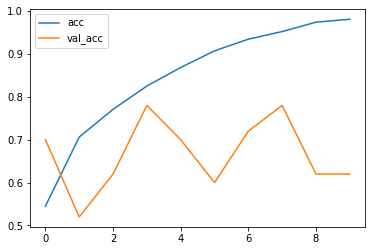

In [ ]:
# Inceptionv4
input_shape = (75, 75, 3)

base = KERAS.applications.InceptionV3(
    weights='imagenet',
    include_top=False, 
    input_shape=input_shape
)

base.trainable = False 



model = KERAS.models.Sequential(
    [
        base, 
        KERAS.layers.Flatten(), 

        KERAS.layers.Dense(128, activation='relu'),

        KERAS.layers.Dense(num_of_class, activation='softmax')
    ]
)


model.compile(
    loss=KERAS.losses.CategoricalCrossentropy(), 
    optimizer=KERAS.optimizers.RMSprop(), 
    metrics=[KERAS.metrics.CategoricalAccuracy()]
)

model.summary()

history = model.fit(
    train_data_norm, train_label_encode,
    batch_size=64,
    epochs=50,
    validation_split=0.01,
    verbose=0,

    use_multiprocessing=True
)

plot_history(history)